<a href="https://colab.research.google.com/github/neklyud/pytorch-tutorial/blob/master/pytorch_tutorial_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# игнорируем предупреждения
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # интерактивный режим



In [0]:
os.listdir('data')
os.mkdir('data/faces/')

In [0]:
from zipfile import ZipFile
from urllib.request import urlopen

URL = 'https://download.pytorch.org/tutorial/faces.zip'
url = urlopen(URL)

ZIP = ZipFile('faces.zip')
ZIP.extractall('data/faces/')



In [0]:
landmarks_frame = pd.read_csv('data/faces/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


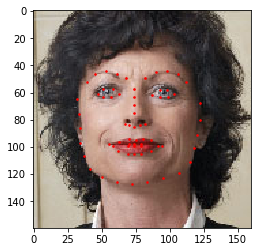

In [0]:
# -*- coding: utf-8 -*-
def show_landmarks(image, landmarks):
    """Показывает изображение с ориентирами"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', 
                c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/faces', img_name)),
               landmarks)
plt.show()

In [0]:
# -*- coding: utf-8 -*-

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Путь к csv файлу с аннотациями.
            root_dir (string): Каталог со всеми изображениями.
            transform (callable, optional): Необязательный transform 
                который будет применен к экземпляру.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (324, 215, 3) (68, 2)


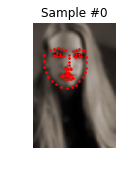

1 (500, 333, 3) (68, 2)


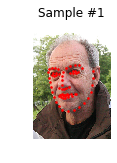

2 (250, 258, 3) (68, 2)


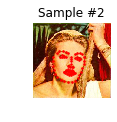

3 (434, 290, 3) (68, 2)


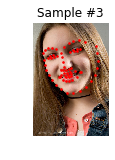

In [0]:
face_dataset = FaceLandmarksDataset(
                   csv_file='data/faces/faces/face_landmarks.csv',
                   root_dir='data/faces/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [0]:
# -*- coding: utf-8 -*-

class Rescale(object):
    """Масштабирует изображение экземпляра в заданный размер.

    Args:
        output_size (tuple or int): Требуемый размер вывода. 
              Если tuple, вывод соответствует output_size. 
              Если int, меньшие края изображения соответствуют 
              output_size сохраняя прежнее соотношение сторон.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = \
                       self.output_size * h / w, self.output_size
            else:
                new_h, new_w = \
                       self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h и w поменялись местами для ориентиров, 
        # потому что для изображений,
        # x и y оси - это оси 1 и 0 соответственно
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Обрезает случайным образом изображение экземпляра.

    Args:
        output_size (tuple or int): Требуемый размер вывода. 
            Если int, выполняется обрезание квадратом.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Преобразовывает ndarrays экземпляра в Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # меняем местами цветовые оси поскольку
        # numpy изображение: H x W x C
        # torch изображение: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

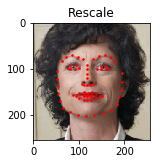

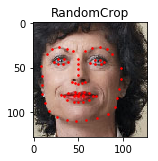

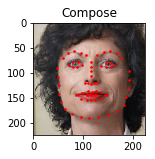

In [0]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Применяем каждую из трансформаций выше к экземпляру.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [0]:
transformed_dataset = FaceLandmarksDataset(
                              csv_file='data/faces/faces/face_landmarks.csv',
                              root_dir='data/faces/faces',
                              transform=transforms.Compose([
                                  Rescale(256),
                                  RandomCrop(224),
                                  ToTensor()
                              ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
